In [1]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, plot_precision_recall_curve, plot_roc_curve
from sklearn.ensemble import RandomForestClassifier

In [2]:
data = pd.read_csv('../input/merge-clean-data/full_tracking_df.csv')
data.drop('Unnamed: 0', axis=1, inplace=True)
data.head()
data.columns

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (32) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index(['gameId', 'playId', 'frameId', 'off_nflId', 'nflId', 'displayName',
       'dist_from_off', 'nearest_is_target', 'distanceFromBall.x',
       'off_distanceFromBall', 'ball_behind_db', 'diff_in_speed',
       'diff_in_acceleration', 'diff_in_dir', 'receiver_behind_db',
       'receiver_distance_from_qb', 'num_of_receivers_nearest',
       'dist_rate_of_change', 'his_off_most_open', 'passResult', 'targetNflId',
       'x', 'y', 'o', 'dir', 's', 'a', 'event', 'epa', 'position', 'route',
       'isDefensivePI', 'targetedReceiver', 'team_name', 'ball_x', 'ball_y',
       'ball_snap_x', 'max_space_available', 'target_x', 'target_y', 'qb_x',
       'qb_y', 'qb_s', 'qb_a', 'distanceFromBall.y', 'distanceFromTarget',
       'distance_from_qb'],
      dtype='object')

In [3]:
data = data[['passResult', 'nearest_is_target', 'targetedReceiver', 'isDefensivePI', 'dist_from_off',
             'qb_s', 'qb_a', 'max_space_available', 'distance_from_qb', 'receiver_distance_from_qb',
             'ball_behind_db', 'diff_in_speed', 'diff_in_acceleration', 'diff_in_dir',
             'his_off_most_open', 'receiver_behind_db', 'dist_rate_of_change',
             'gameId', 'playId', 'frameId', 'off_nflId', 'nflId', 'displayName', 'event']]
data = data[data.isDefensivePI != True]

# holding_data.to_csv('holding_data.csv')

data.dropna(inplace=True)
data.reset_index(inplace=True)

holding_data = data[['gameId', 'playId', 'frameId', 'off_nflId', 'nflId', 'displayName', 'event']]

data.head()

,index,passResult,nearest_is_target,targetedReceiver,isDefensivePI,dist_from_off,qb_s,qb_a,max_space_available,distance_from_qb,...,his_off_most_open,receiver_behind_db,dist_rate_of_change,gameId,playId,frameId,off_nflId,nflId,displayName,event
0,0,C,0.0,0.0,False,1.920339,0.00,0.00,90.11,10.234813,...,0.0,1.89,0.000000,2018090600,75,11,2533040,79848.0,Malcolm Jenkins,ball_snap
1,1,C,0.0,0.0,False,1.922134,0.00,0.00,90.11,10.240400,...,0.0,1.89,0.000000,2018090600,75,12,2533040,79848.0,Malcolm Jenkins,None
2,2,C,0.0,0.0,False,1.912302,0.03,0.82,90.11,10.246024,...,0.0,1.88,0.000000,2018090600,75,13,2533040,79848.0,Malcolm Jenkins,None
3,3,C,0.0,0.0,False,1.908743,0.22,2.24,90.11,10.239258,...,0.0,1.88,-0.006038,2018090600,75,14,2533040,79848.0,Malcolm Jenkins,None
4,4,C,0.0,0.0,False,1.889047,0.61,3.46,90.11,10.265988,...,0.0,1.86,-0.017214,2018090600,75,15,2533040,79848.0,Malcolm Jenkins,None


In [4]:
xComp_dat = data[(data.event == 'pass_forward') & (data.nearest_is_target == 1)] # & (isDefensivePI == False)
# filtering like this assumes that if the pass were to be thrown right now and the nearest offensive player to a defender were to be targeted
# what are the odds the pass is completed

data = data[['dist_from_off', 'qb_s', 'qb_a', 'max_space_available', 'distance_from_qb',
             'receiver_distance_from_qb', 'ball_behind_db', 'diff_in_speed', 'diff_in_acceleration',
             'diff_in_dir', 'his_off_most_open', 'receiver_behind_db', 'dist_rate_of_change']]

# xComp_dat = xComp_dat[['passResult', 'nearest_is_target', 'targetedReceiver', 'isDefensivePI', 'dist_from_off',
#                        'qb_s', 'qb_a', 'max_space_available', 'distance_from_qb', 'receiver_distance_from_qb',
#                        'ball_behind_db', 'diff_in_speed', 'diff_in_acceleration', 'diff_in_dir',
#                        'his_off_most_open', 'receiver_behind_db', 'dist_rate_of_change',
#                        'gameId', 'playId', 'frameId', 'off_nflId', 'nflId', 'displayName']]
xComp_dat.head()
# features to add ... typeDropback, penalty on play

,index,passResult,nearest_is_target,targetedReceiver,isDefensivePI,dist_from_off,qb_s,qb_a,max_space_available,distance_from_qb,...,his_off_most_open,receiver_behind_db,dist_rate_of_change,gameId,playId,frameId,off_nflId,nflId,displayName,event
173,173,C,1.0,0.0,False,4.160048,0.84,2.05,90.11,26.933854,...,0.0,4.16,0.077024,2018090600,75,36,2495454,2555383.0,Jalen Mills,pass_forward
283,283,I,1.0,0.0,False,4.687569,0.46,2.25,49.17,15.607181,...,0.0,4.23,-0.237617,2018090600,146,31,2560854,2555383.0,Jalen Mills,pass_forward
528,528,C,1.0,0.0,False,4.243218,2.38,0.91,50.00,18.825995,...,0.0,-4.07,0.912738,2018090600,190,39,2495454,79848.0,Malcolm Jenkins,pass_forward
574,574,C,1.0,0.0,False,10.081791,2.38,0.91,50.00,30.930058,...,0.0,8.52,-0.094449,2018090600,190,39,2495454,2495613.0,Corey Graham,pass_forward
712,712,C,1.0,0.0,False,18.706804,2.38,0.91,50.00,21.892960,...,1.0,-4.57,0.039277,2018090600,190,39,2495454,2555383.0,Jalen Mills,pass_forward


In [5]:
# xComp_dat['passResult'] = np.where(xComp_dat['isDefensivePI'] == True, 'C', xComp_dat['passResult'])

xComp_dat['complete'] = np.where(xComp_dat['passResult'] == 'C', 1, 0)

xComp_dat = xComp_dat[['dist_from_off', 'qb_s', 'qb_a', 'max_space_available', 'distance_from_qb',
                       'receiver_distance_from_qb', 'ball_behind_db', 'diff_in_speed', 'diff_in_acceleration',
                      'diff_in_dir', 'his_off_most_open', 'receiver_behind_db', 'dist_rate_of_change', 'complete']]
xComp_dat.head()
# must add distance from ball at time of pass_forward i.e. depth of target or distance ball traveled

,dist_from_off,qb_s,qb_a,max_space_available,distance_from_qb,receiver_distance_from_qb,ball_behind_db,diff_in_speed,diff_in_acceleration,diff_in_dir,his_off_most_open,receiver_behind_db,dist_rate_of_change,complete
173,4.160048,0.84,2.05,90.11,26.933854,24.009259,0.0,1.57,-4.49,20.40,0.0,4.16,0.077024,1
283,4.687569,0.46,2.25,49.17,15.607181,11.034174,0.0,0.91,2.42,129.71,0.0,4.23,-0.237617,0
528,4.243218,2.38,0.91,50.00,18.825995,23.063187,0.0,-6.18,0.31,86.32,0.0,-4.07,0.912738,1
574,10.081791,2.38,0.91,50.00,30.930058,23.063187,0.0,-3.79,-0.45,15.00,0.0,8.52,-0.094449,1
712,18.706804,2.38,0.91,50.00,21.892960,23.063187,0.0,-4.02,-2.96,15.83,1.0,-4.57,0.039277,1


In [6]:
y_data = np.array(xComp_dat['complete'])
x_data = xComp_dat.drop('complete', axis = 1)

In [7]:
data.head()

,dist_from_off,qb_s,qb_a,max_space_available,distance_from_qb,receiver_distance_from_qb,ball_behind_db,diff_in_speed,diff_in_acceleration,diff_in_dir,his_off_most_open,receiver_behind_db,dist_rate_of_change
0,1.920339,0.00,0.00,90.11,10.234813,9.538433,0.0,0.01,0.01,258.48,0.0,1.89,0.000000
1,1.922134,0.00,0.00,90.11,10.240400,9.530519,0.0,0.01,0.01,276.29,0.0,1.89,0.000000
2,1.912302,0.03,0.82,90.11,10.246024,9.533651,0.0,-0.02,-0.29,280.46,0.0,1.88,0.000000
3,1.908743,0.22,2.24,90.11,10.239258,9.544658,0.0,-0.07,-0.50,34.84,0.0,1.88,-0.006038
4,1.889047,0.61,3.46,90.11,10.265988,9.563472,0.0,-0.22,-1.20,9.95,0.0,1.86,-0.017214


In [8]:
def trainSets(x_data,y_data):
    # args: pandas dataframe, pandas dataframe
    # return: pandas dataframe, pandas dataframe, pandas series, pandas series
    x_train, x_test, y_train, y_test = train_test_split(
        x_data, y_data,
        test_size=0.15, train_size=.85,
        random_state=614, shuffle=True)
    return x_train, x_test, y_train, y_test
model_data = trainSets(x_data, y_data)

In [9]:
class RFClassifier():
    def randomForestClassifier(self,x_train, x_test, y_train):
        # args: pandas dataframe, pandas dataframe, pandas series
        # return: RandomForestClassifier object, numpy array, numpy array
        rf_clf = RandomForestClassifier(random_state=614,
                                        max_depth = 20,
                                        max_features = 'auto',
                                        min_samples_leaf = 4,
                                        min_samples_split = 10,
                                        n_estimators = 100)
        rf_clf.fit(x_train, y_train)
        y_predict_train = rf_clf.predict(x_train)
        y_predict_train = np.array(y_predict_train)
        y_predict_test = rf_clf.predict(x_test)
        y_predict_test = np.array(y_predict_test)
        
        return rf_clf, y_predict_train, y_predict_test
    
    def rfTrainAccuracy(self,y_train,y_predict_train):
        # args: pandas series, numpy array
        # return: float
        y_predict_train = np.rint(y_predict_train)
        train_accuracy = accuracy_score(y_train, y_predict_train)
        return train_accuracy
    
    def rfTestAccuracy(self,y_test,y_predict_test):
        # args: pandas series, numpy array
        # return: float
        y_predict_test = np.rint(y_predict_test)
        test_accuracy = accuracy_score(y_test, y_predict_test)
        return test_accuracy

    def rfFeatureImportance(self,rf_clf):
        # args: RandomForestClassifier object
        # return: float array
        feature_importance = rf_clf.feature_importances_
        # std = np.std([tree.feature_importances_ for tree in rf_clf.estimators_],
        #      axis=0)
        # indices = np.argsort(importances)[::-1]
        return feature_importance
    
    def sortedRFFeatureImportanceIndicies(self,rf_clf):
        # args: RandomForestClassifier object
        # return: int array
        importances = rf_clf.feature_importances_

        sorted_indices = np.argsort(importances)[::-1]
        # -------------------------------
        return sorted_indices
    
    def hyperParameterTuning(self,rf_clf,x_train,y_train):
        # args: RandomForestClassifier object, pandas dataframe, pandas series
        # return: GridSearchCV object
        parameters = {'max_depth': [5, 10, 20, 30],
                      'max_features': ['auto', 'sqrt'],
                      'min_samples_leaf': [1, 2, 4],
                      'min_samples_split': [2, 5, 10],
                      'n_estimators': [50, 100, 200, 250, 400]}
        gscv_rfc = GridSearchCV(rf_clf, parameters)
        gscv_rfc.fit(x_train, y_train)
        return gscv_rfc
    
    def bestParams(self,gscv_rfc):
        # args:  GridSearchCV object
        # return: parameter dict
        best_params = gscv_rfc.best_params_
        return best_params
    
    def bestScore(self,gscv_rfc):
        # args: GridSearchCV object
        # return: float
        best_score = gscv_rfc.best_score_
        return best_score

In [10]:
train_x = model_data[0]
test_x = model_data[1]
train_y = model_data[2]
test_y = model_data[3]

In [11]:
rf = RFClassifier()
model = rf.randomForestClassifier(train_x, test_x, train_y)
pred_y_train = model[1]
pred_y_test = model[2]
model = model[0]

print("Train Acc:")
print(rf.rfTrainAccuracy(train_y, pred_y_train))
print("Test Acc:")
print(rf.rfTestAccuracy(test_y, pred_y_test))
print('Recall:')
print(recall_score(test_y, pred_y_test))
print('Precision:')
print(precision_score(test_y, pred_y_test))
print('F1 Score:')
print(f1_score(test_y, pred_y_test))


print("Feature Importance: ") 
print(rf.rfFeatureImportance(model))

print("Sorted Indices:")
print(rf.sortedRFFeatureImportanceIndicies(model))

# gridCV = rf.hyperParameterTuning(model, train_x, train_y)

# print("Best Params:")
# print(rf.bestParams(gridCV))

# print("Best Score:")
# print(rf.bestScore(gridCV))

# Best Params from GridSearch w/ no penalties
# {'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}

Train Acc:
0.9218122877431306
Test Acc:
0.6843025797988631
Recall:
0.8010670731707317
Precision:
0.6951058201058201
F1 Score:
0.7443342776203966
Feature Importance: 
[0.12333002 0.07784032 0.06737964 0.08192253 0.0834932  0.12078984
 0.00013941 0.08046195 0.07609513 0.07947786 0.00499799 0.09600487
 0.10806724]
Sorted Indices:
[ 0  5 12 11  4  3  7  9  1  8  2 10  6]


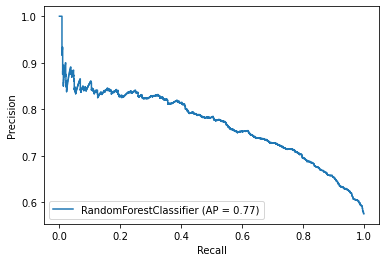

In [12]:
plot_precision_recall_curve(model, test_x, test_y)

[Text(0, 0, 'dist_from_off'),
 Text(0, 0, 'qb_s'),
 Text(0, 0, 'qb_a'),
 Text(0, 0, 'max_space_available'),
 Text(0, 0, 'distance_from_qb'),
 Text(0, 0, 'receiver_distance_from_qb'),
 Text(0, 0, 'ball_behind_db'),
 Text(0, 0, 'diff_in_speed'),
 Text(0, 0, 'diff_in_acceleration'),
 Text(0, 0, 'diff_in_dir'),
 Text(0, 0, 'his_off_most_open'),
 Text(0, 0, 'receiver_behind_db'),
 Text(0, 0, 'dist_rate_of_change')]

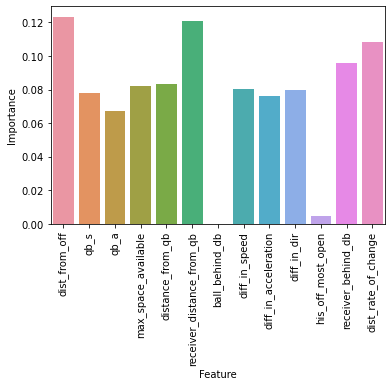

In [13]:
feat_imp = pd.DataFrame(train_x.columns, rf.rfFeatureImportance(model)).reset_index()
feat_imp.columns = ['Importance', 'Feature']

import seaborn as sns
import matplotlib.pyplot as plt

g = sns.barplot(x="Feature", y="Importance", data=feat_imp)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

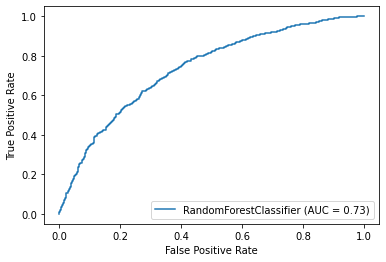

In [14]:
plot_roc_curve(model, test_x, test_y)

In [15]:
# Create this instance to predict the probability of a completion no a full train of the data
# The accuracy will be skewed, of course, but will be illustrative of the point of the process

rf_clf = RandomForestClassifier(random_state=614,
                                max_depth = 20,
                                max_features = 'auto',
                                min_samples_leaf = 4,
                                min_samples_split = 10,
                                n_estimators = 100)
rf_clf.fit(x_data, y_data)
comp_prob = rf_clf.predict_proba(data)
comp_prob

array([[0.35135396, 0.64864604],
       [0.35135396, 0.64864604],
       [0.31573759, 0.68426241],
       ...,
       [0.23545465, 0.76454535],
       [0.28024266, 0.71975734],
       [0.26675467, 0.73324533]])

In [16]:
comp_prob = [x[1] for x in comp_prob]
data['comp_prob'] = comp_prob

In [17]:
comp_prob_dat = pd.concat([holding_data, data], axis=1)
comp_prob_dat.to_csv('comp_prob_dat.csv')

In [18]:
holding_data.shape

(3319906, 7)